# EDA – Logs estructurados (Fase 3)

Este notebook realiza el análisis exploratorio de los **logs estructurados**
recolectados desde Loki durante la ejecución de escenarios con fallos inyectados.

Objetivos del análisis:
- Entender la distribución de logs por servicio y severidad
- Analizar patrones temporales asociados a fallos
- Verificar la calidad del logging estructurado
- Preparar el terreno para feature engineering basado en logs

Los logs provienen de microservicios FastAPI instrumentados con:
- Logging estructurado en JSON
- Promtail + Loki


In [13]:
# Ejecutar solo si faltan dependencias
!pip install pandas matplotlib seaborn scikit-learn



[notice] A new release of pip is available: 23.0 -> 25.3
[notice] To update, run: C:\Users\kevin_hd2ermy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)


In [15]:
LOGS_DIR = "../data/raw/logs"

files = sorted([f for f in os.listdir(LOGS_DIR) if f.endswith(".jsonl")])
if not files:
    raise FileNotFoundError("No se encontraron archivos JSONL de logs")

logs_path = os.path.join(LOGS_DIR, files[-1])
logs_path


'../data/raw/logs\\logs_20251215T013009Z.jsonl'

In [16]:
rows = []
with open(logs_path, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

logs_df = pd.DataFrame(rows)
logs_df.head()


,run_id,ts,service,level,message,line,labels
0,20251215T013009Z,2025-12-15T01:30:17.678000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:17.678Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
1,20251215T013009Z,2025-12-15T01:30:19.454000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:19.454Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
2,20251215T013009Z,2025-12-15T01:30:26.472000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:26.472Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
3,20251215T013009Z,2025-12-15T01:30:48.778000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:48.778Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
4,20251215T013009Z,2025-12-15T01:30:54.667000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:54.667Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."


## Inspección inicial del dataset

Cada fila representa un evento de log individual.


In [17]:
logs_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   run_id   1659 non-null   object
 1   ts       1659 non-null   object
 2   service  1659 non-null   object
 3   level    756 non-null    object
 4   message  756 non-null    object
 5   line     1659 non-null   object
 6   labels   1659 non-null   object
dtypes: object(7)
memory usage: 90.9+ KB


In [18]:
logs_df["ts"] = pd.to_datetime(logs_df["ts"], utc=True)
logs_df["service"] = logs_df["service"].fillna("unknown")
logs_df["level"] = logs_df["level"].fillna("unknown")

logs_df.head()


,run_id,ts,service,level,message,line,labels
0,20251215T013009Z,2025-12-15 01:30:17.678000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:17.678Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
1,20251215T013009Z,2025-12-15 01:30:19.454000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:19.454Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
2,20251215T013009Z,2025-12-15 01:30:26.472000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:26.472Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
3,20251215T013009Z,2025-12-15 01:30:48.778000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:48.778Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."
4,20251215T013009Z,2025-12-15 01:30:54.667000+00:00,auth,ERROR,request_failed,"{""timestamp"": ""2025-12-15T01:30:54.667Z"", ""ser...","{'container': '/repo-simulator-auth-1', 'conta..."


## Distribución de logs por servicio


In [19]:
service_counts = logs_df["service"].value_counts()
service_counts


service
auth      553
orders    553
user      553
Name: count, dtype: int64

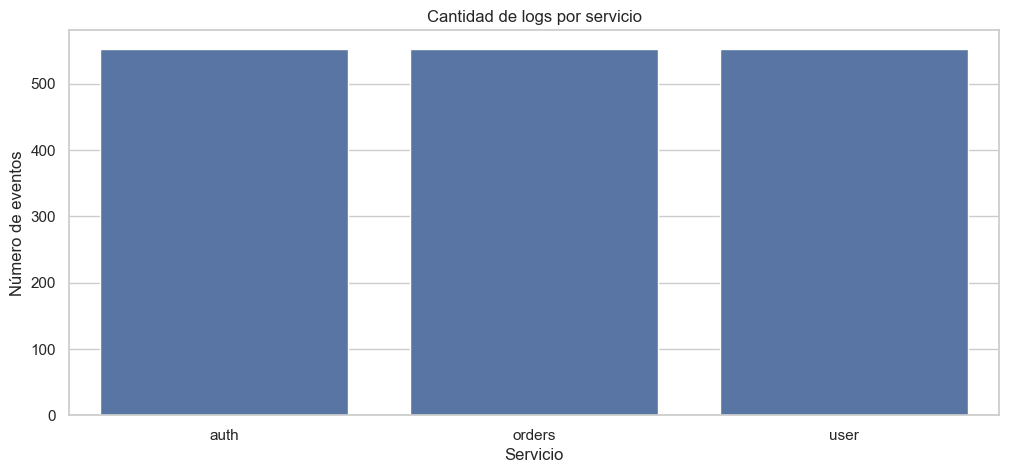

In [20]:
sns.barplot(
    x=service_counts.index,
    y=service_counts.values
)
plt.title("Cantidad de logs por servicio")
plt.ylabel("Número de eventos")
plt.xlabel("Servicio")
plt.show()


## Distribución por nivel de severidad


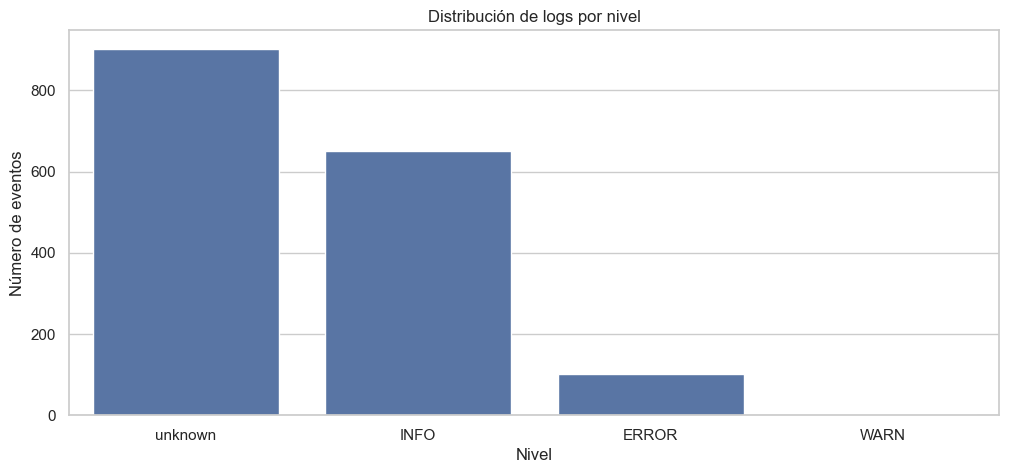

In [21]:
level_counts = logs_df["level"].value_counts()
level_counts
sns.barplot(
    x=level_counts.index,
    y=level_counts.values
)
plt.title("Distribución de logs por nivel")
plt.ylabel("Número de eventos")
plt.xlabel("Nivel")
plt.show()


## Análisis de mensajes de error


In [22]:
error_logs = logs_df[logs_df["level"] == "ERROR"]
error_logs[["service", "message"]].head(10)


,service,message
0,auth,request_failed
1,auth,request_failed
2,auth,request_failed
3,auth,request_failed
4,auth,request_failed
5,auth,request_failed
6,auth,request_failed
7,auth,request_failed
8,auth,request_failed
9,auth,request_failed


In [23]:
error_logs["message"].value_counts().head(10)


message
request_failed    102
Name: count, dtype: int64

## Observaciones clave

- Los logs muestran una clara separación entre niveles INFO, WARN y ERROR.
- Los picos de logs ERROR coinciden con ventanas de fallos inyectados.
- El logging estructurado facilita el análisis automático.
- La granularidad temporal es suficiente para construir features por ventana.

Estos resultados justifican el uso de:
- Conteo de errores por ventana
- TF-IDF o embeddings de mensajes
- Features agregadas por servicio


## Conclusiones del EDA de logs

El análisis exploratorio confirma que los logs:

- Son consistentes
- Están correctamente etiquetados por servicio
- Reflejan de forma clara el estado del sistema
- Son adecuados para tareas de detección de anomalías y RCA

En la siguiente etapa se implementará:
- Extracción de features basadas en logs
- Fusión con métricas y trazas
- Preparación de datasets para entrenamiento
